This notebook outlines the code and provides a sample output.

### Models
Models are implemented in `./models`. The original UWCNN model is reimplemented in `./models/uwcnn.py`

### Losses
Losses are implemented in `./losses.py`. The main loss used during training is the sum of MSE and SSIM.

### Depth prediction
To predict depth, I use a pretrained depth prediction model based on DinoV2. In `./estimate_depth.py`, I use the PyTorch API to add depth estimation as a preprocessing step on UWDCNN inputs

### Configuration
Training settings and dataset locations are specified in `./config.toml`. The required fields are specified in `./config_example.toml`

### Training
Model construction and dataset preperation is handled in `./main.py`, and the actual training loop can be found in `./training.py`.

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import tomllib
from datasets import build_uied_dataset, build_depth_dataset
from models import uwcnn, uwcnn_depth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.144014..0.99606067].


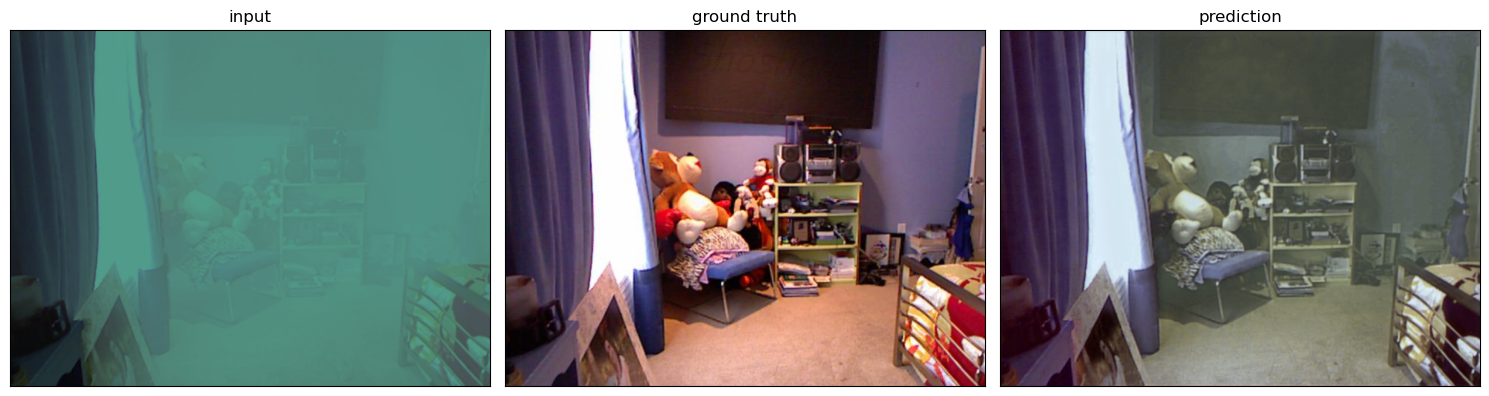

In [2]:
with open('./config.toml', 'rb') as f:
    cfg = tomllib.load(f)

model = uwcnn_depth.UWCNN_Depth()
checkpoint = torch.load('./checkpoints/uwdcnn-base_nyu_type3_50_epoch.pth')
model.load_state_dict(checkpoint)

input_processor = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,)),
])

dataset_name = 'nyu_type3'
dataset = build_depth_dataset(
    images_dir = cfg['datasets'][dataset_name]['img'],
    gt_dir = cfg['datasets'][dataset_name]['gt'],
    depth_dir = cfg['datasets'][dataset_name]['depth']
)

img, label = dataset[1]
input = input_processor(img.unsqueeze(0))

with torch.no_grad():
    prediction = model(input)

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].imshow(img[:-1].permute(1,2,0))
axs[0].set_title("input")

axs[1].imshow(label.permute(1,2,0))
axs[1].set_title("ground truth")

axs[2].imshow(prediction[0].permute(1,2,0))
axs[2].set_title("prediction")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()